!pip install wikipedia-api

!pip install umap-learn

!pip install --upgrade wikipedia-api

In [1]:
!pip install plotly

!pip install yellowbrick

In [2]:
import re
import umap
import time
import pandas as pd
import wikipediaapi
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import KElbowVisualizer  
from sklearn.feature_extraction.text import TfidfVectorizer

from config import *

C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
not_working_pages = []

wiki_object = wikipediaapi.Wikipedia("wikiScraping (fake@gmail.com)", "en")

page_test = wiki_object.page("Python_(programming_language)")
page_text = wiki_object.extracts(page=page_test)

print(f"Page title: {page_test.title}")
print(f"Text : {page_text}")
print(len(page_text))

Page title: Python (programming language)
Text : Python is a high-level, general-purpose programming language. Its design philosophy emphasizes code readability with the use of significant indentation.
Python is dynamically type-checked and garbage-collected. It supports multiple programming paradigms, including structured (particularly procedural), object-oriented and functional programming. It is often described as a "batteries included" language due to its comprehensive standard library.
Guido van Rossum began working on Python in the late 1980s as a successor to the ABC programming language and first released it in 1991 as Python 0.9.0. Python 2.0 was released in 2000. Python 3.0, released in 2008, was a major revision not completely backward-compatible with earlier versions. Python 2.7.18, released in 2020, was the last release of Python 2.
Python consistently ranks as one of the most popular programming languages, and has gained widespread use in the machine learning community.
9

In [4]:
# Extract pages from other fields and save it as JSON file


def ExtractWikiPages(topics : list, wiki_object):
    """
    Fetches and returns the cleaned text content of a Wikipedia page for a given title.
    
    Parameters: 
        topics (dict) : List of topics
        wiki_objet : API instance
            
    returns:
        wiki_data : dict
        Dict of extracted topics, with topics as key and extracted page as value
    """
    wiki_data = {}
    
    for topic in topics:
        wiki_data[topic] = cleaning_text(wiki_object.extracts(wiki_object.page(topic)))

    return  wiki_data    

In [5]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional for better language support
nltk.download('punkt')     # Required for tokenization
nltk.download('averaged_perceptron_tagger') 
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_

True

In [6]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag

In [7]:
# Function to get the Part of Speech (POS) tag for each word
def get_wordnet_pos(word):
    """Map POS tag to first character to use with WordNetLemmatizer"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [8]:
def cleaning_text(text: str):
    """
    Cleans extracted Wikipedia page text by removing punctuation, non-alpha characters,
    and multiple spaces while converting to lowercase.

    Arguments:
        text (str): Raw text extracted from the Wikipedia page.

    Returns:
        str: Cleaned text.
    """
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\n", "", text)  # Remove newline characters
    text = re.sub(r"\s+", " ", text)  # Replace multiple spaces with a single space
    text = re.sub(r"[.,;:\'\"“”’]", "", text)  # Remove punctuations
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove non-alpha characters
    
    lemmatizer = WordNetLemmatizer()
    
    tokens = word_tokenize(text, language='english')
    lemmatized_sentence = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    
    text = " ".join(lemmatized_sentence)
    
    return text

check clean-text library

In [9]:
def vectorize(data: pd.DataFrame):
    """
    Vectorizes the corpus using the TF-IDF method, creating a feature matrix where each row corresponds
    to a document, and each column corresponds to a word in the vocabulary.

    Arguments:
        data (pd.DataFrame): DataFrame of documents to vectorize.

    Returns:
        pd.DataFrame: TF-IDF weighted term-document matrix as a DataFrame.
        vectorizer (TfidfVectorizer): Fitted TF-IDF vectorizer object for future use.
    """
    # Initialize the TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=3000, stop_words="english")

    # Fit and transform the documents
    X = vectorizer.fit_transform(data["Text"])

    # Convert the sparse matrix into a dense DataFrame
    tfidf_df = pd.DataFrame(
        X.toarray(), columns=vectorizer.get_feature_names_out(), index=data.index
    )

    return tfidf_df, vectorizer

In [10]:
def vectorize_new_topic(new_topic_texts: list, vectorizer: object):
    """
    Vectorizes new topics using the already fitted TF-IDF vectorizer from the original corpus.

    Arguments:
        new_topic_texts (list): List of texts for new topics to be vectorized.
        vectorizer (TfidfVectorizer): The pre-fitted TF-IDF vectorizer.

    Returns:
        new_topic_vector (sparse matrix): TF-IDF matrix for the new topics.
        features (array): List of feature names (words) corresponding to the TF-IDF vectors.
    """
    new_topic_vectors = vectorizer.transform(new_topic_texts)

    return new_topic_vectors, vectorizer.get_feature_names_out()

In [11]:
def project_and_visualize_clusters(
    original_data: pd.DataFrame,
    new_topic_vectors,
    index: list,
    new_topic_labels: list,
    features: list,
):
    """
    Combines the original data and new topics, applies UMAP for dimensionality reduction,
    clusters the combined data using k-means, and visualizes the results using a scatter plot.

    Arguments:
        original_data (pd.DataFrame): The TF-IDF matrix of the original corpus.
        new_topic_vectors (sparse matrix): The TF-IDF vectorized data for new topics.
        index (list): List of labels or categories for the original data.
        new_topic_labels (list): Labels for the new topics.
        features (list): Feature names (words) corresponding to the combined data.
    """
    # Combine original data with the new topic
    new_topic_df = pd.DataFrame(
        new_topic_vectors.toarray(), columns=features, index=new_topic_labels
    )
    combined_data = pd.concat([original_data, new_topic_df])

    # Apply UMAP for dimensionality reduction on combined data
    umap_model = umap.UMAP(n_components=3, random_state=42)
    tfidf_3d_combined = umap_model.fit_transform(combined_data)

    # Use KElbowVisualizer to find the optimal number of clusters
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2, 10))
    visualizer.fit(tfidf_3d_combined)  # Fit the UMAP reduced data to the visualizer
    optimal_clusters = visualizer.elbow_value_  # Get the optimal number of clusters
    print(f"Optimal number of clusters: {optimal_clusters}")

    # Run k-Means clustering on the combined UMAP-reduced data
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    clusters = kmeans.fit_predict(tfidf_3d_combined)

    # Create a DataFrame for visualization
    umap_df_combined = pd.DataFrame(tfidf_3d_combined, columns=["UMAP1", "UMAP2", "UMAP3"])
    umap_df_combined["category"] = index + new_topic_labels
    umap_df_combined["cluster"] = clusters

    # 3D Scatter Plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection="3d")

    # Scatter plot in 3D
    scatter = ax.scatter(
        umap_df_combined["UMAP1"],
        umap_df_combined["UMAP2"],
        umap_df_combined["UMAP3"],
        c=umap_df_combined["cluster"],
        cmap='hsv',
        s=50,  # Size of points
    )
    
    # Add annotations (True Class) to the points
    for i in range(umap_df_combined.shape[0]):
        ax.text(
            umap_df_combined["UMAP1"].iloc[i],  # x-coordinate
            umap_df_combined["UMAP2"].iloc[i],  # y-coordinate
            umap_df_combined["UMAP3"].iloc[i],  # z-coordinate
            umap_df_combined["category"].iloc[i],  # True class or label
            fontsize=9,
            color="black",
            ha="right",
            va="bottom",
        )
        
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_zlabel("UMAP3")
    
    # Legend
    handles, labels = scatter.legend_elements()
    custom_labels = [f"Cluster {i}" for i in range(optimal_clusters)]
    ax.legend(handles, custom_labels, title="Clusters", loc='upper right')

    plt.title("3D UMAP Projection with New Topic and Updated Clusters")

    formatted_time = time.strftime("%Y-%m-%d_%H-%M-%S")
    filename = f'{OUTPUT_DIR}/scraping_wikipedia_result_3d_{formatted_time}.png'
    
    plt.savefig(filename, format='png')


In [12]:
def project_and_visualize_clusters_interactive(
    original_data: pd.DataFrame,
    new_topic_vectors,
    index: list,
    new_topic_labels: list,
    features: list,
):
    """
    Combines the original data and new topics, applies UMAP for dimensionality reduction,
    clusters the combined data using k-means, and visualizes the results using an interactive
    3D scatter plot with Plotly.

    Arguments:
        original_data (pd.DataFrame): The TF-IDF matrix of the original corpus.
        new_topic_vectors (sparse matrix): The TF-IDF vectorized data for new topics.
        index (list): List of labels or categories for the original data.
        new_topic_labels (list): Labels for the new topics.
        features (list): Feature names (words) corresponding to the combined data.
    """
    # Combine original data with the new topic
    new_topic_df = pd.DataFrame(
        new_topic_vectors.toarray(), columns=features, index=new_topic_labels
    )
    combined_data = pd.concat([original_data, new_topic_df])

    # Apply UMAP for dimensionality reduction on combined data (3D)
    umap_model = umap.UMAP(n_components=3, random_state=42)
    tfidf_3d_combined = umap_model.fit_transform(combined_data)
    
    # Use KElbowVisualizer to find the optimal number of clusters
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2, 10))
    visualizer.fit(tfidf_3d_combined)  # Fit the UMAP reduced data to the visualizer
    optimal_clusters = visualizer.elbow_value_  # Get the optimal number of clusters
    print(f"Optimal number of clusters: {optimal_clusters}")

    # Run k-Means clustering on the combined UMAP-reduced data
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    clusters = kmeans.fit_predict(tfidf_3d_combined)

    # Create a DataFrame for the UMAP-reduced data
    umap_df_combined = pd.DataFrame(
        tfidf_3d_combined, columns=["UMAP1", "UMAP2", "UMAP3"]
    )
    umap_df_combined["category"] = index + new_topic_labels
    umap_df_combined["cluster"] = clusters

    # Create an interactive 3D scatter plot using Plotly
    fig = go.Figure()

    # Add scatter plot for each cluster
    for cluster in range(optimal_clusters):
        cluster_data = umap_df_combined[umap_df_combined["cluster"] == cluster]
        fig.add_trace(go.Scatter3d(
            x=cluster_data["UMAP1"],
            y=cluster_data["UMAP2"],
            z=cluster_data["UMAP3"],
            mode='markers',
            marker=dict(size=6),
            name=f"Cluster {cluster}",
            text=cluster_data["category"],  # Display category on hover
            hoverinfo='text',
        ))

    # Update layout for better visualization
    fig.update_layout(
        scene=dict(
            xaxis_title='UMAP1',
            yaxis_title='UMAP2',
            zaxis_title='UMAP3'
        ),
        title="Interactive 3D UMAP Projection with Clusters",
        legend_title="Clusters"
    )

    fig.show()

In [16]:
categories = {
"AI": AI_PAGES,
"CS": COMPUTER_SCIENCE_PAGES,
"Law": LAW_PAGES,
"Literature": LITERATURE_PAGES,
"Philosophy": PHILOSOPHY_PAGES,
"History": HISTORY_PAGES,
"Sports": SPORTS_PAGES,
"Music": MUSIC_PAGES
}

In [17]:
documents = {}

for category, pages in categories.items():
    wiki_data = ExtractWikiPages(pages, wiki_object=wiki_object)
    wiki_data = {topic: text for topic, text in wiki_data.items() if text != ""}
    
    documents[category] = wiki_data.items()
    
documents

{'AI': dict_items([('Artificial_intelligence', 'artificial intelligence ai refers to the capability of computational system to perform task typically associate with human intelligence such a learn reason problemsolving perception and decisionmaking it be a field of research in computer science that develops and study method and software that enable machine to perceive their environment and use learn and intelligence to take action that maximize their chance of achieve define goal such machine may be call aishighprofile application of ai include advanced web search engine eg google search recommendation system use by youtube amazon and netflix virtual assistant eg google assistant siri and alexa autonomous vehicle eg waymo generative and creative tool eg chatgpt and ai art and superhuman play and analysis in strategy game eg chess and go however many ai application be not perceive a ai a lot of cut edge ai have filter into general application often without be call ai because once someth

In [18]:
data = []

for category, pages in documents.items():
    for title, text in pages:
        data.append({"Category": category, "Title": title, "Text": text})

data = pd.DataFrame(data).set_index("Category")
data

,Title,Text
Category,,
AI,Artificial_intelligence,artificial intelligence ai refers to the capab...
AI,Machine_learning,machine learn ml be a field of study in artifi...
AI,Deep_learning,deep learn be a subset of machine learn that f...
AI,Neural_network,a neural network be a group of interconnect un...
AI,Natural_language_processing,natural language processing nlp be a subfield ...
...,...,...
Music,Choir,a choir kwire also know a a chorale or chorus ...
Music,Musical_instrument,a musical instrument be a device create or ada...
Music,Composer,a composer be a person who writes music the te...


In [19]:
# Vectorize the documents using TF-IDF
tf_idf, vectorizer = vectorize(data)
tf_idf

,abbey,abbreviate,abductive,ability,able,abolish,abolition,absence,absolute,abstract,...,wto,yangtze,year,york,young,youth,yuan,zealand,zero,zone
Category,,,,,,,,,,,,,,,,,,,,,
AI,0.0,0.0,0.0,0.073713,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AI,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AI,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AI,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AI,0.0,0.0,0.0,0.136914,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Music,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Music,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.073187,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Music,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
test_topic_pages = [
    "Electric_car",
    "Internet",
    "Feminism",
    "Cyberbullying",
    "Global_warming",
    "Vikings",
    "Napoleon",
    "COVID-19",
    "Harry_Potter",
    "Social_media",
]

test_topic_labels = [f"{title}" for title in test_topic_pages]

In [21]:
# Get texts and index for new topics.
test_topic_texts = ExtractWikiPages(test_topic_pages, wiki_object=wiki_object).values()
test_topic_texts

dict_values(['an electric car or electric vehicle ev be a passenger automobile that be propel by an electric traction motor use electrical energy a the primary source of propulsion the term normally refers to a plugin electric vehicle typically a battery electric vehicle bev which only us energy store in onboard battery pack but broadly may also include plugin hybrid electric vehicle phev rangeextended electric vehicle reev and fuel cell electric vehicle fcev which can convert electric power from other fuel via a generator or a fuel cellcompared to conventional internal combustion engine ice vehicle electric car be quieter more responsive have superior energy conversion efficiency and no exhaust emission a well a a low overall carbon footprint from manufacturing to end of life even when a power plant supply the electricity might add to it emission due to the superior efficiency of electric motor electric car also generate less waste heat thus reduce the need for engine cool system that

In [22]:
# Vectorize the new corpus.
new_topic_vectors, features = vectorize_new_topic(test_topic_texts, vectorizer)

C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\jo

Optimal number of clusters: 4


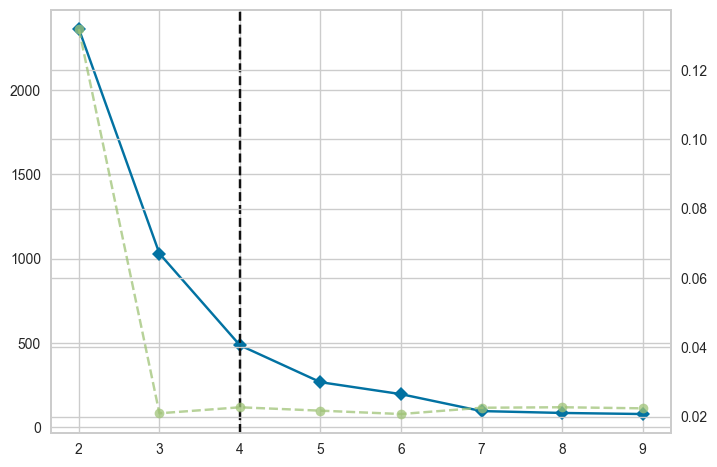

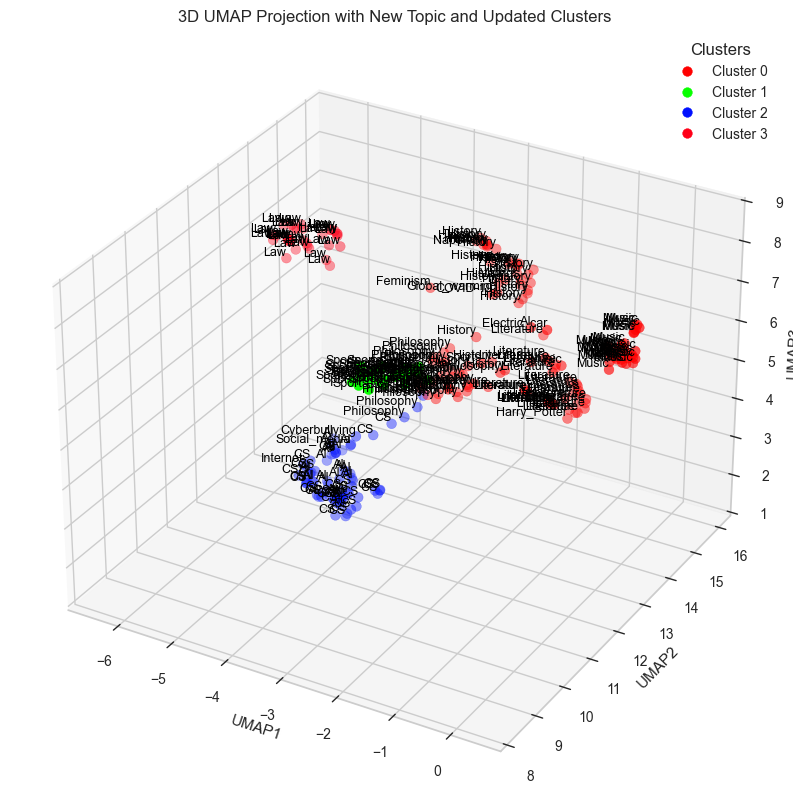

In [23]:
# Project and visualize clusters.
project_and_visualize_clusters(
    tf_idf,
    new_topic_vectors,
    index=data.index.tolist(),
    new_topic_labels=test_topic_labels,
    features=features,
)

C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Optimal number of clusters: 4


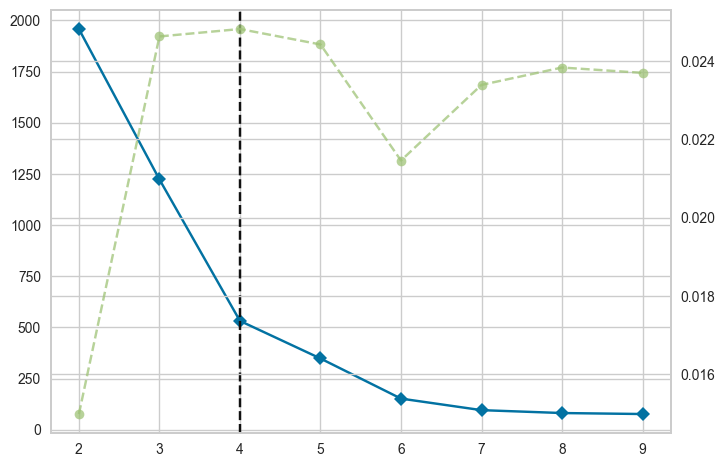

In [24]:
project_and_visualize_clusters_interactive(
    tf_idf,
    new_topic_vectors,
    index=data.index.tolist(),
    new_topic_labels=test_topic_labels,
    features=features,
)